# Mushroom Classification using Decision Trees and Random Forests

This project implements a decision tree classifier from scratch to classify mushrooms as edible or poisonous using the Mushroom dataset. The tree uses **recursive binary splits** based on information gain computed from three impurity criteria:
- Gini index
- Entropy
- Misclassification error

The implementation includes several stopping criteria, such as:
- maximum tree depth
- minimum number of samples required to split
- node purity (all samples belong to one class)

The dataset is preprocessed, encoded, and split into **training, validation,** and **test** sets.
A grid search is used for **hyperparameter tuning**, and final models are evaluated using accuracy, confusion matrices, and classification reports.
A **Random Forest** classifier is also implemented using bootstrapping to compare performance with a single decision tree. 

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### Data Loading and Preprocessing

The `primary_data.csv` file contains some metrical columns represented as string ranges (e.g., "[4, 8]") that are converted to numerical values by taking their average. The secondary dataset `secondary_data.csv` is cleaner and more suitable for machine learning tasks. Column names are stripped of whitespace to ensure consistency. Missing and unusual values are also checked and handled accordingly.

In [2]:
def parse_measured_value(cell):
    if isinstance(cell, str) and cell.startswith("[") and "," in cell:
        nums = [float(x.strip()) for x in cell.strip("[]").split(",")]
        return sum(nums) / len(nums)
    try:
        return float(cell)
    except:
        return float("nan")

metrical_cols = ["cap-diameter", "stem-height", "stem-width"]

df_primary = pd.read_csv("primary_data.csv", sep=";", encoding="utf-8")
df_primary.columns = df_primary.columns.str.strip()

for col in metrical_cols:
    df_primary[col] = df_primary[col].apply(parse_measured_value)

print("Primary cleaned dtypes:")
print(df_primary[metrical_cols].dtypes)
print(df_primary.head())

df_secondary = pd.read_csv("secondary_data.csv", sep=";", encoding="utf-8")
df_secondary.columns = df_secondary.columns.str.strip()

print("Secondary raw dtypes:")
print(df_secondary[metrical_cols].dtypes)
print(df_secondary.head())

Primary cleaned dtypes:
cap-diameter    float64
stem-height     float64
stem-width      float64
dtype: object
           family               name class  cap-diameter cap-shape  \
0  Amanita Family         Fly Agaric     p          15.0    [x, f]   
1  Amanita Family        Panther Cap     p           7.5    [p, x]   
2  Amanita Family  False Panther Cap     p          12.5    [x, f]   
3  Amanita Family        The Blusher     e          10.0    [x, f]   
4  Amanita Family          Death Cap     p           8.5    [x, f]   

  Cap-surface cap-color does-bruise-or-bleed gill-attachment gill-spacing  \
0      [g, h]    [e, o]                  [f]             [e]          NaN   
1         [g]       [n]                  [f]             [e]          NaN   
2         NaN    [g, n]                  [f]             [e]          NaN   
3         NaN       [n]                  [t]             NaN          NaN   
4         [h]       [r]                  [f]             NaN          [c]   

   ...

### Exploratory Data Analysis (Primary Dataset)
The primary dataset is explored to understand distributions, missing values, numeric feature ranges, and family/class relationships.
Although this dataset is not used for model training, it provides useful biological context and helps verify data quality.

The primary dataset is explored to understand distributions, missing values, numeric feature ranges, and family/class relationships.
Although this dataset is not used for model training, it provides useful biological context and helps verify data quality.

In [3]:
print("Dataset shape:", df_primary.shape)
print(df_primary['class'].value_counts(normalize=True))

Dataset shape: (173, 23)
class
p    0.554913
e    0.445087
Name: proportion, dtype: float64


/var/folders/j1/gkl50w091pg7k58s7y1040r80000gn/T/ipykernel_35146/1693941641.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, order=order, palette="Set2")


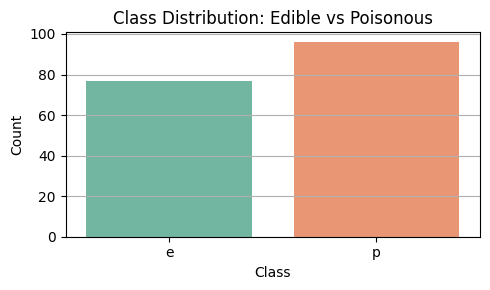

In [4]:
class_counts = df_primary['class'].value_counts()

# Visualize class distribution
plt.figure(figsize=(5, 3))
order = ['e', 'p'] if set(class_counts.index) == set(['e', 'p']) else class_counts.index
sns.barplot(x=class_counts.index, y=class_counts.values, order=order, palette="Set2")
plt.title("Class Distribution: Edible vs Poisonous")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis="y")
plt.tight_layout()
plt.show()



In [5]:
missing_df = pd.DataFrame({
    "blank": (df_primary == '').sum(),
    "question": (df_primary == '?').sum(),
    "NaN": df_primary.isnull().sum()
})
missing_df = missing_df.loc[missing_df.any(axis=1)]
print(missing_df)

                   blank  question  NaN
cap-diameter           0         0    1
Cap-surface            0         0   40
gill-attachment        0         0   28
gill-spacing           0         0   71
stem-height            0         0    3
stem-width             0         0   11
stem-root              0         0  146
stem-surface           0         0  108
veil-type              0         0  164
veil-color             0         0  152
ring-type              0         0    7
Spore-print-color      0         0  155


#### Numeric Feature Distributions

In [6]:
num_cols = ['cap-diameter', 'stem-height', 'stem-width']
print("\nSummary statistics for numeric features:")
print(df_primary[num_cols].describe())


Summary statistics for numeric features:
       cap-diameter  stem-height  stem-width
count    172.000000   170.000000  162.000000
mean       6.487791     6.705882   12.705247
std        3.945632     3.172360    9.883715
min        0.700000     1.500000    0.750000
25%        3.500000     5.000000    6.000000
50%        6.000000     6.000000   11.500000
75%        8.500000     7.500000   17.500000
max       19.000000    25.000000   70.000000


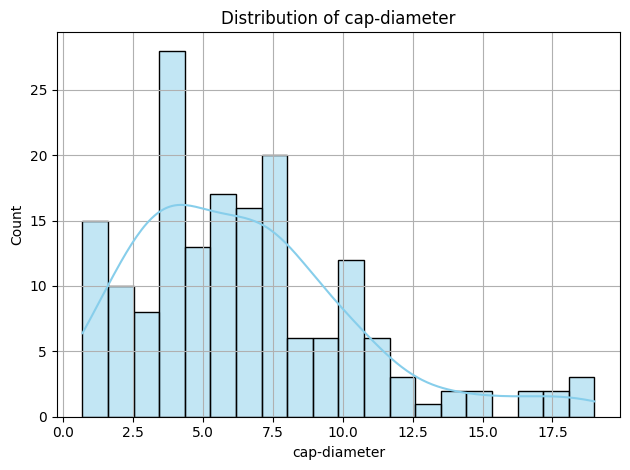

In [7]:
sns.histplot(df_primary["cap-diameter"], bins=20, kde=True, color='skyblue')
plt.title("Distribution of cap-diameter")
plt.xlabel("cap-diameter")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/j1/gkl50w091pg7k58s7y1040r80000gn/T/ipykernel_35146/1798123754.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


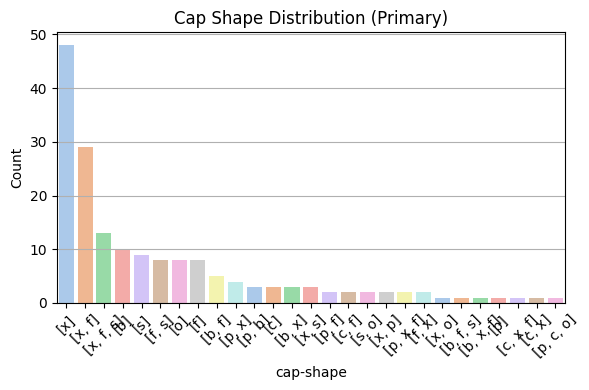

In [8]:
# Bar Plot for cap-shape in df_primary
plt.figure(figsize=(6, 4))
sns.countplot(
    data=df_primary, x='cap-shape',
    order=df_primary['cap-shape'].value_counts().index,
    palette="pastel"
)
plt.title("Cap Shape Distribution (Primary)")
plt.xlabel("cap-shape")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

#### Cap Shape and Family Composition
The `family` column in `primary_data.csv` indicates the taxonomic family for each mushroom species. Visualizing this gives insight into species diversity across families and can reveal which families are most represented in the dataset.

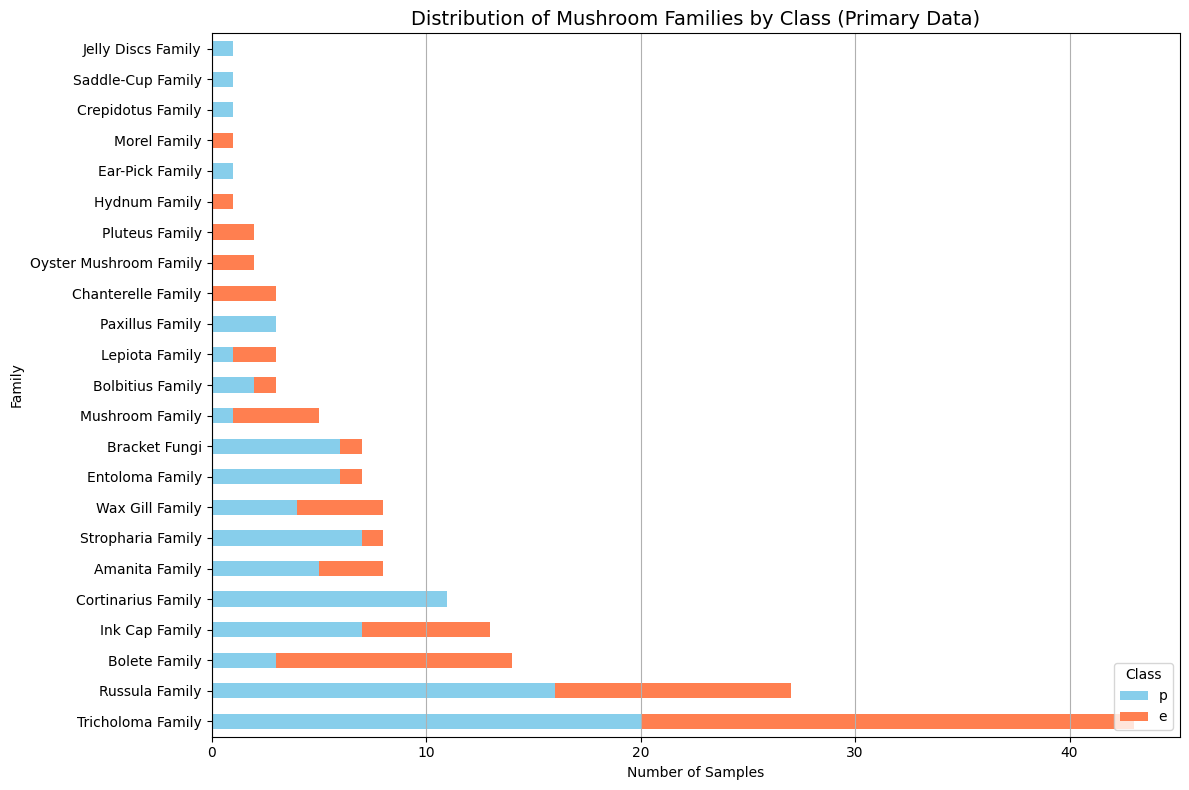

In [9]:
family_counts = df_primary.groupby(['family', 'class']).size().unstack(fill_value=0)
family_counts['total'] = family_counts.sum(axis=1)
family_counts_sorted = family_counts.sort_values('total', ascending=False)
family_counts_sorted[['p', 'e']].plot(
    kind='barh', stacked=True, color=['skyblue', 'coral'], figsize=(12, 8)
)
plt.title("Distribution of Mushroom Families by Class (Primary Data)", fontsize=14)
plt.xlabel("Number of Samples")
plt.ylabel("Family")
plt.legend(title="Class", loc='lower right')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


#### Correlation Matrix

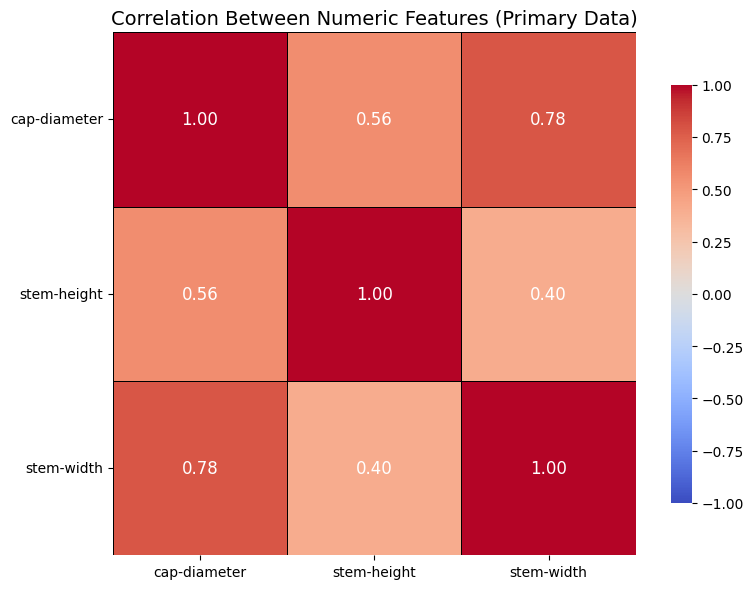

In [10]:
num_cols = ['cap-diameter', 'stem-height', 'stem-width']

corr = df_primary[num_cols].corr()

plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1, square=True,
                 linewidths=0.5, linecolor='black', cbar_kws={"shrink": 0.8})

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        value = corr.iloc[i, j]
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}", color='white',
                ha='center', va='center', fontsize=12)

plt.title("Correlation Between Numeric Features (Primary Data)", fontsize=14)
plt.xticks(np.arange(len(num_cols)) + 0.5, num_cols)
plt.yticks(np.arange(len(num_cols)) + 0.5, num_cols, rotation=0)
plt.tight_layout()
plt.show()

### Exploratory Data Analysis (Secondary Dataset)
The secondary dataset serves as the primary source for model training.
Visualizations illustrate class distribution, numeric feature ranges, class-dependent differences, and common categories such as habitat types.

In [11]:
print("Dataset shape:", df_secondary.shape)
print(df_secondary.head())

Dataset shape: (61069, 21)
  class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0     p         15.26         x           g         o                    f   
1     p         16.60         x           g         o                    f   
2     p         14.07         x           g         o                    f   
3     p         14.17         f           h         e                    f   
4     p         14.64         x           h         o                    f   

  gill-attachment gill-spacing gill-color  stem-height  ...  stem-root  \
0               e          NaN          w        16.95  ...          s   
1               e          NaN          w        17.99  ...          s   
2               e          NaN          w        17.80  ...          s   
3               e          NaN          w        15.77  ...          s   
4               e          NaN          w        16.53  ...          s   

  stem-surface stem-color veil-type veil-color has-ring rin

#### Numeric Feature Distributions and Class Differences


/var/folders/j1/gkl50w091pg7k58s7y1040r80000gn/T/ipykernel_35146/299023987.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, order=order, palette="Set2")


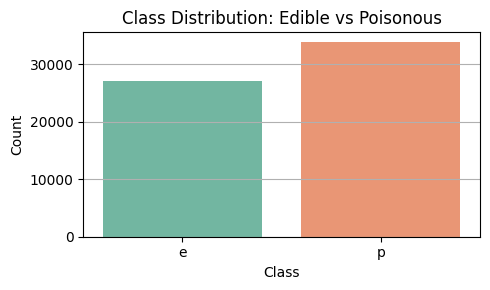

In [12]:
class_counts = df_secondary['class'].value_counts()

# Plot class distribution
plt.figure(figsize=(5, 3))
order = ['e', 'p'] if set(class_counts.index) == set(['e', 'p']) else class_counts.index
sns.barplot(x=class_counts.index, y=class_counts.values, order=order, palette="Set2")
plt.title("Class Distribution: Edible vs Poisonous")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [13]:
missing_df_secondary = pd.DataFrame({
    "blank": (df_secondary == '').sum(),
    "question": (df_secondary == '?').sum(),
    "NaN": df_secondary.isnull().sum()
})
missing_df_secondary = missing_df_secondary.loc[missing_df_secondary.any(axis=1)]
print(missing_df_secondary)

                   blank  question    NaN
cap-surface            0         0  14120
gill-attachment        0         0   9884
gill-spacing           0         0  25063
stem-root              0         0  51538
stem-surface           0         0  38124
veil-type              0         0  57892
veil-color             0         0  53656
ring-type              0         0   2471
spore-print-color      0         0  54715


/var/folders/j1/gkl50w091pg7k58s7y1040r80000gn/T/ipykernel_35146/3582278344.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_secondary, x="class", y=col, ax=axes[i, 1],
/var/folders/j1/gkl50w091pg7k58s7y1040r80000gn/T/ipykernel_35146/3582278344.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_secondary, x="class", y=col, ax=axes[i, 1],
/var/folders/j1/gkl50w091pg7k58s7y1040r80000gn/T/ipykernel_35146/3582278344.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_secondary, x="class", y=col, ax=axes[i, 1],


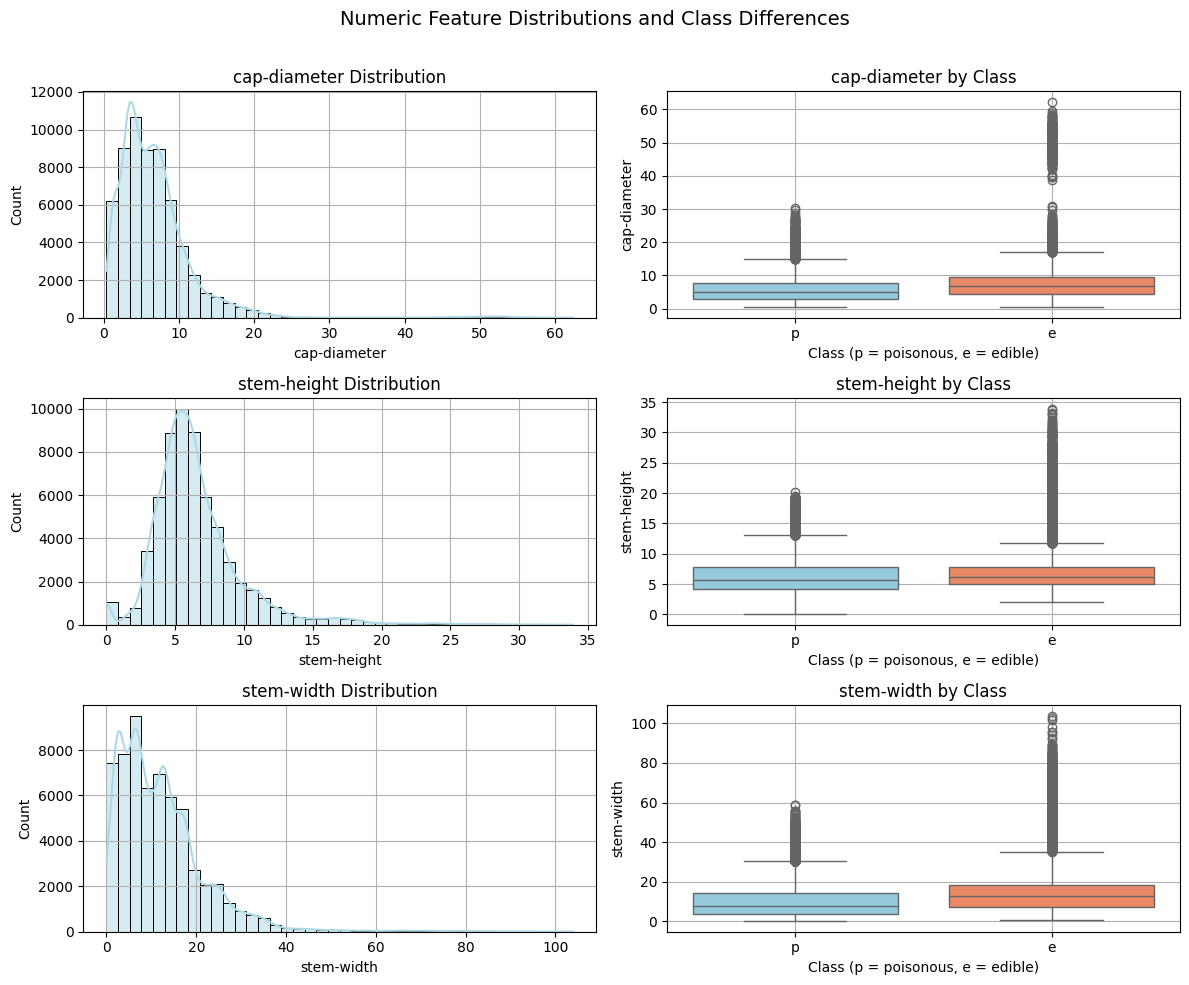

In [14]:
num_cols = ["cap-diameter", "stem-height", "stem-width"]

fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 10))

for i, col in enumerate(num_cols):
    # Left: Histogram + KDE
    sns.histplot(df_secondary[col], ax=axes[i, 0], kde=True, bins=40, color='lightblue')
    axes[i, 0].set_title(f"{col} Distribution", fontsize=12)
    axes[i, 0].set_xlabel(col, fontsize=10)
    axes[i, 0].set_ylabel("Count", fontsize=10)
    axes[i, 0].grid(True)

    # Right: Boxplot by Class
    sns.boxplot(data=df_secondary, x="class", y=col, ax=axes[i, 1],
                palette=["skyblue", "coral"])
    axes[i, 1].set_title(f"{col} by Class", fontsize=12)
    axes[i, 1].set_xlabel("Class (p = poisonous, e = edible)", fontsize=10)
    axes[i, 1].set_ylabel(col, fontsize=10)
    axes[i, 1].grid(True)

plt.suptitle("Numeric Feature Distributions and Class Differences", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


#### Top Categorical Features by Class


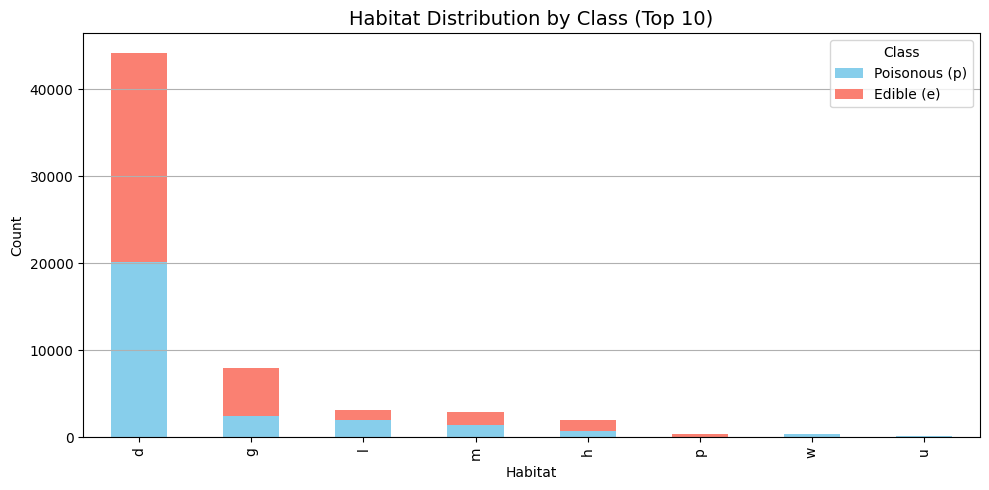

In [15]:
top_habitats = df_secondary['habitat'].value_counts().nlargest(10).index
subset_habitat = df_secondary[df_secondary['habitat'].isin(top_habitats)]

habitat_counts = subset_habitat.groupby(['habitat', 'class']).size().unstack(fill_value=0)
habitat_counts['total'] = habitat_counts.sum(axis=1)
habitat_counts = habitat_counts.sort_values('total', ascending=False).drop(columns='total')

# Plot
habitat_counts.plot(kind="bar", stacked=True, color=["skyblue", "salmon"], figsize=(10, 5))
plt.title("Habitat Distribution by Class (Top 10)", fontsize=14)
plt.xlabel("Habitat")
plt.ylabel("Count")
plt.legend(title="Class", labels=["Poisonous (p)", "Edible (e)"])
plt.grid(axis="y")
plt.tight_layout()
plt.show()


### Comparison of Numeric Feature Distributions: Primary vs. Secondary


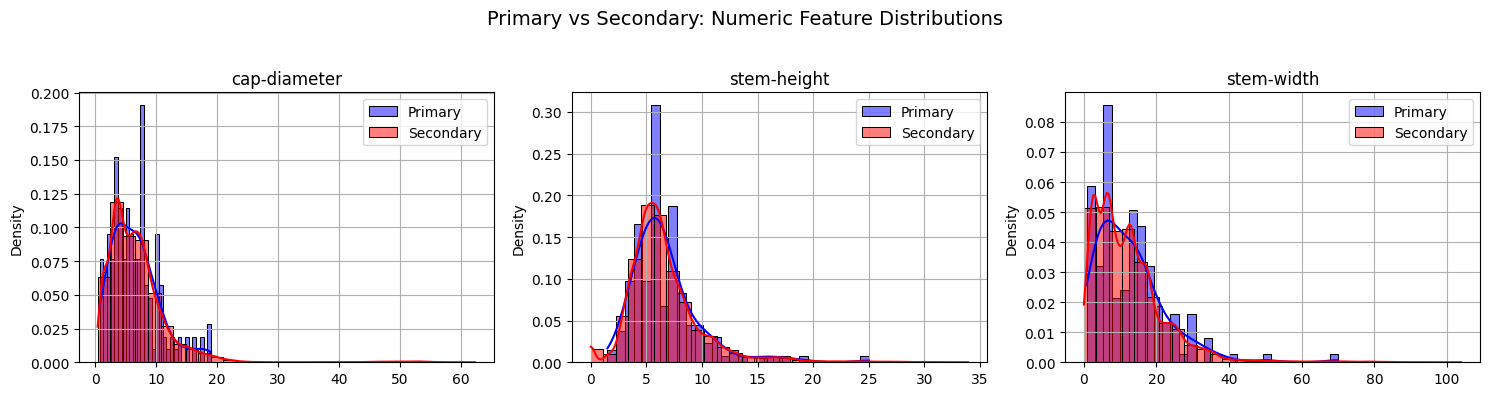

In [16]:
num_cols = ["cap-diameter", "stem-height", "stem-width"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, num_cols):
    sns.histplot(df_primary[col], ax=ax, bins=30, color='blue', label='Primary',
                 kde=True, stat="density", common_norm=False)
    sns.histplot(df_secondary[col], ax=ax, bins=30, color='red', label='Secondary',
                 kde=True, stat="density", common_norm=False)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.legend()
    ax.grid(True)

plt.suptitle("Primary vs Secondary: Numeric Feature Distributions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Feature Encoding and Dataset Preparation

The target variable is transformed into a binary label:
- 1 for poisonous
- 0 for edible

All categorical features are encoded as integer codes to enable numerical processing in the custom tree implementation.

In [18]:
y = (df_secondary["class"] == "p").astype(int).to_numpy()

X_df = df_secondary.drop(columns=["class"])
for col in X_df.columns:
    X_df[col] = X_df[col].astype("category").cat.codes

X = X_df.to_numpy()
feature_names = X_df.columns.tolist()

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (61069, 20)
Target vector shape: (61069,)


### Dataset Splitting

A three-way split is performed:
- 80% — training
- 10% — validation
- 10% — test

The validation set is used exclusively for hyperparameter tuning.
The test set is held out for the final, unbiased evaluation of model performance.

In [19]:
# First split off 20% of the data as a temp set
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

# Then split the temp set evenly into validation and test sets (10% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=0
)

print("Training set:", X_train_full.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Training set: (48855, 20)
Validation set: (6107, 20)
Test set: (6107, 20)


### Custom Decision Tree Classifier

A decision tree classifier was implemented from scratch. Each internal node splits the data using a binary test on a single feature, comparing the feature value to a selected threshold.

Information gain is computed using one of three impurity measures:
- Gini impurity
- Entropy
- Classification error

Tree expansion stops when any of the following conditions is met:
- maximum depth is reached
- the node does not contain enough samples to split
- the node is pure (all samples belong to one class)


In [20]:
class Node:
    def __init__(self, is_leaf=False, prediction=None, feature_index=None, threshold=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = None
        self.right = None

    def evaluate(self, x):
        if self.is_leaf:
            return self.prediction
        if x[self.feature_index] <= self.threshold:
            return self.left.evaluate(x)
        else:
            return self.right.evaluate(x)


In [21]:
class TreePredictor:
    def __init__(self, max_depth=5, min_samples_split=2, criterion="gini"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.root = None

    def _impurity(self, y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        if self.criterion == "gini":
            return 1 - np.sum(probs**2)
        elif self.criterion == "entropy":
            return -np.sum(probs * np.log2(probs + 1e-9))
        elif self.criterion == "error":
            return 1 - np.max(probs)
        else:
            raise ValueError(f"Unknown criterion: {self.criterion}")

    def _information_gain(self, y, left_y, right_y):
        n = len(y)
        parent_impurity = self._impurity(y)
        n_left = len(left_y)
        n_right = len(right_y)
        if n_left == 0 or n_right == 0:
            return 0
        left_imp = self._impurity(left_y)
        right_imp = self._impurity(right_y)
        weighted = (n_left / n) * left_imp + (n_right / n) * right_imp
        return parent_impurity - weighted

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        best_gain = -1
        best_feature = None
        best_threshold = None
        best_left_mask = None
        best_right_mask = None

        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
                gain = self._information_gain(y, y[left_mask], y[right_mask])
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold
                    best_left_mask = left_mask
                    best_right_mask = right_mask

        return best_feature, best_threshold, best_left_mask, best_right_mask

    def _majority_class(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    def _build_tree(self, X, y, depth):
        if (depth >= self.max_depth or
            len(y) < self.min_samples_split or
            len(np.unique(y)) == 1):
            return Node(is_leaf=True, prediction=self._majority_class(y))

        feature_index, threshold, left_mask, right_mask = self._best_split(X, y)

        if feature_index is None:
            return Node(is_leaf=True, prediction=self._majority_class(y))

        node = Node(
            is_leaf=False,
            feature_index=feature_index,
            threshold=threshold
        )
        node.left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node.right = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return node

    def fit(self, X, y):
        self.root = self._build_tree(X, y, 0)

    def predict(self, X):
        return np.array([self.root.evaluate(x) for x in X])

### Hyperparameter Tuning

A grid search is performed over various values of `max_depth` and `min_samples_split`. The goal is to minimize validation error and avoid overfitting. A heatmaps are generated to visualize the performance across the parameter space.

In [22]:
print(" Criterion: gini")
best_score = float("inf")
best_params = {}
results_gini = []

for depth in [3, 5, 7, 9]:
    for min_split in [2, 5, 10]:
        tree = TreePredictor(max_depth=depth, min_samples_split=min_split, criterion="gini")
        tree.fit(X_train_full, y_train_full)

        train_pred = tree.predict(X_train_full)
        val_pred = tree.predict(X_val)

        train_error = 1 - accuracy_score(y_train_full, train_pred)
        val_error = 1 - accuracy_score(y_val, val_pred)

        print(f"depth={depth}, min_split={min_split} → train_error={train_error:.4f}, val_error={val_error:.4f}")

        results_gini.append((depth, min_split, train_error, val_error))

        if val_error < best_score:
            best_score = val_error
            best_params = {"criterion": "gini", "max_depth": depth, "min_samples_split": min_split}

print("Best for gini:", best_params, "→ Validation Error:", best_score)


 Criterion: gini
depth=3, min_split=2 → train_error=0.2949, val_error=0.2952
depth=3, min_split=5 → train_error=0.2949, val_error=0.2952
depth=3, min_split=10 → train_error=0.2949, val_error=0.2952
depth=5, min_split=2 → train_error=0.2413, val_error=0.2384
depth=5, min_split=5 → train_error=0.2413, val_error=0.2384
depth=5, min_split=10 → train_error=0.2413, val_error=0.2384
depth=7, min_split=2 → train_error=0.1421, val_error=0.1497
depth=7, min_split=5 → train_error=0.1421, val_error=0.1497
depth=7, min_split=10 → train_error=0.1421, val_error=0.1497
depth=9, min_split=2 → train_error=0.0694, val_error=0.0698
depth=9, min_split=5 → train_error=0.0694, val_error=0.0698
depth=9, min_split=10 → train_error=0.0695, val_error=0.0698
Best for gini: {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 2} → Validation Error: 0.06975601768462425


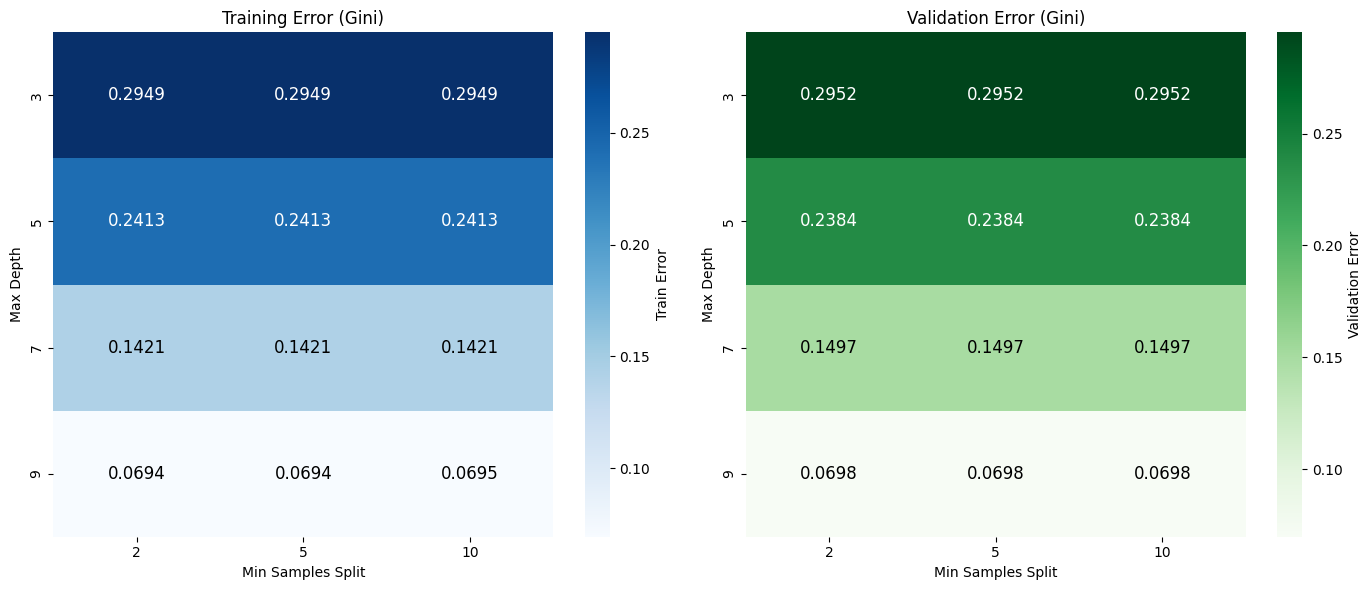

In [23]:
def annotate_heatmap_with_contrast(ax, data, fmt=".4f"):

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data.iloc[i, j]
            text = format(val, fmt)
            facecolor = ax.collections[0].get_facecolor()[i * data.shape[1] + j]
            r, g, b, a = facecolor
            brightness = r * 0.299 + g * 0.587 + b * 0.114  

            text_color = "black" if brightness > 0.5 else "white"
            ax.text(j + 0.5, i + 0.5, text,
                    ha='center', va='center', color=text_color, fontsize=12)

df_results_gini = pd.DataFrame(results_gini, columns=["Depth", "MinSplit", "TrainErr", "ValErr"])

pivot_train_gini = df_results_gini.pivot(index="Depth", columns="MinSplit", values="TrainErr")

pivot_val_gini = df_results_gini.pivot(index="Depth", columns="MinSplit", values="ValErr")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training Error Heatmap
sns.heatmap(
    pivot_train_gini,
    annot=False, 
    fmt=".4f",
    cmap="Blues",
    ax=axes[0],
    cbar_kws={"label": "Train Error"}
)
annotate_heatmap_with_contrast(axes[0], pivot_train_gini)
axes[0].set_title("Training Error (Gini)")
axes[0].set_xlabel("Min Samples Split")
axes[0].set_ylabel("Max Depth")

# Validation Error Heatmap
sns.heatmap(
    pivot_val_gini,
    annot=False,
    fmt=".4f",
    cmap="Greens",
    ax=axes[1],
    cbar_kws={"label": "Validation Error"}
)
annotate_heatmap_with_contrast(axes[1], pivot_val_gini)
axes[1].set_title("Validation Error (Gini)")
axes[1].set_xlabel("Min Samples Split")
axes[1].set_ylabel("Max Depth")

plt.tight_layout()
plt.show()


In [24]:
print("\n Criterion: entropy")
best_score = float("inf")
best_params = {}
results_entropy = []

for depth in [3, 5, 7, 9]:
    for min_split in [2, 5, 10]:
        tree = TreePredictor(max_depth=depth, min_samples_split=min_split, criterion="entropy")
        tree.fit(X_train_full, y_train_full)

        train_pred = tree.predict(X_train_full)
        val_pred = tree.predict(X_val)

        train_error = 1 - accuracy_score(y_train_full, train_pred)
        val_error = 1 - accuracy_score(y_val, val_pred)

        print(f"depth={depth}, min_split={min_split} → train_error={train_error:.4f}, val_error={val_error:.4f}")

        results_entropy.append((depth, min_split, train_error, val_error))

        if val_error < best_score:
            best_score = val_error
            best_params = {"criterion": "entropy", "max_depth": depth, "min_samples_split": min_split}

print("Best for entropy:", best_params, "→ Validation Error:", best_score)



 Criterion: entropy
depth=3, min_split=2 → train_error=0.3062, val_error=0.3067
depth=3, min_split=5 → train_error=0.3062, val_error=0.3067
depth=3, min_split=10 → train_error=0.3062, val_error=0.3067
depth=5, min_split=2 → train_error=0.2685, val_error=0.2643
depth=5, min_split=5 → train_error=0.2685, val_error=0.2643
depth=5, min_split=10 → train_error=0.2686, val_error=0.2643
depth=7, min_split=2 → train_error=0.2039, val_error=0.1994
depth=7, min_split=5 → train_error=0.2039, val_error=0.1994
depth=7, min_split=10 → train_error=0.2040, val_error=0.1994
depth=9, min_split=2 → train_error=0.1233, val_error=0.1261
depth=9, min_split=5 → train_error=0.1234, val_error=0.1261
depth=9, min_split=10 → train_error=0.1235, val_error=0.1261
Best for entropy: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 2} → Validation Error: 0.12608482069756022


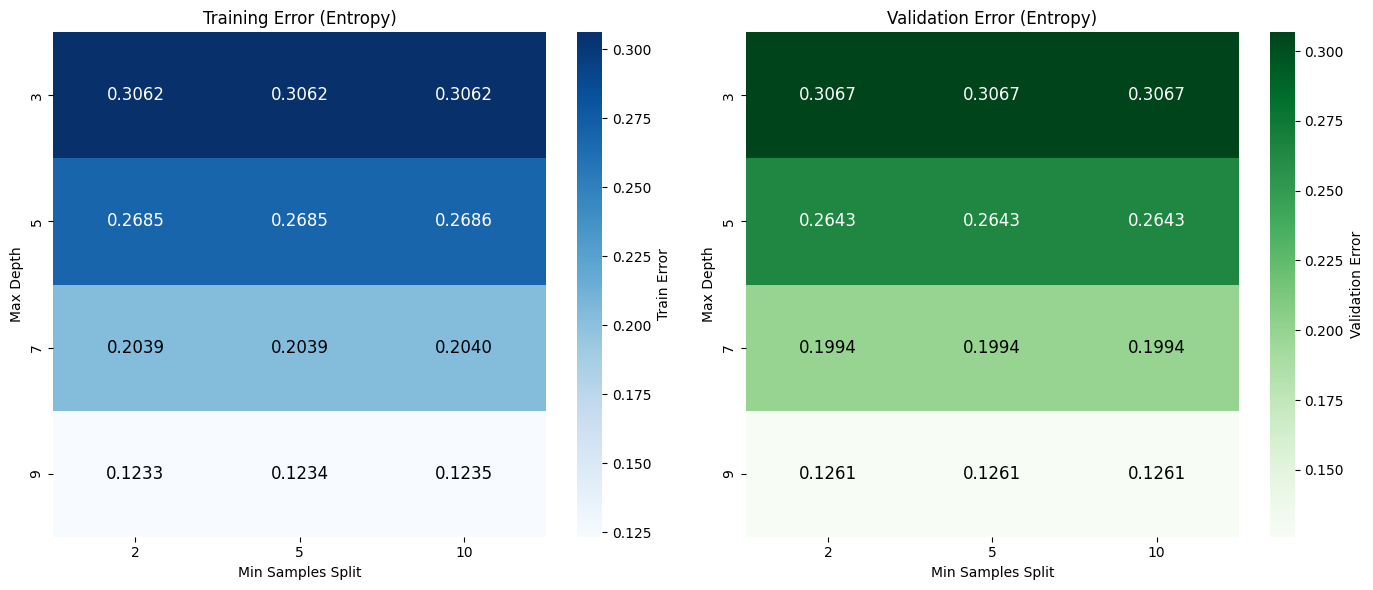

In [25]:
df_results_entropy = pd.DataFrame(results_entropy, columns=["Depth", "MinSplit", "TrainErr", "ValErr"])

pivot_train_entropy = df_results_entropy.pivot(index="Depth", columns="MinSplit", values="TrainErr")
pivot_val_entropy = df_results_entropy.pivot(index="Depth", columns="MinSplit", values="ValErr")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training Error Heatmap
sns.heatmap(
    pivot_train_entropy,
    annot=False,
    fmt=".4f",
    cmap="Blues",
    ax=axes[0],
    cbar_kws={"label": "Train Error"}
)
annotate_heatmap_with_contrast(axes[0], pivot_train_entropy)
axes[0].set_title("Training Error (Entropy)")
axes[0].set_xlabel("Min Samples Split")
axes[0].set_ylabel("Max Depth")

# Validation Error Heatmap
sns.heatmap(
    pivot_val_entropy,
    annot=False,
    fmt=".4f",
    cmap="Greens",
    ax=axes[1],
    cbar_kws={"label": "Validation Error"}
)
annotate_heatmap_with_contrast(axes[1], pivot_val_entropy)
axes[1].set_title("Validation Error (Entropy)")
axes[1].set_xlabel("Min Samples Split")
axes[1].set_ylabel("Max Depth")

plt.tight_layout()
plt.show()


In [26]:
print("\n Criterion: error (misclassification)")
best_score = float("inf")
best_params = {}
results_misclassification = []

for depth in [3, 5, 7, 9]:
    for min_split in [2, 5, 10]:
        tree = TreePredictor(max_depth=depth, min_samples_split=min_split, criterion="error")
        tree.fit(X_train_full, y_train_full)

        train_pred = tree.predict(X_train_full)
        val_pred = tree.predict(X_val)

        train_error = 1 - accuracy_score(y_train_full, train_pred)
        val_error = 1 - accuracy_score(y_val, val_pred)

        print(f"depth={depth}, min_split={min_split} → train_error={train_error:.4f}, val_error={val_error:.4f}")

        results_misclassification.append((depth, min_split, train_error, val_error))

        if val_error < best_score:
            best_score = val_error
            best_params = {"criterion": "error", "max_depth": depth, "min_samples_split": min_split}

print("Best for error:", best_params, "→ Validation Error:", best_score)



 Criterion: error (misclassification)
depth=3, min_split=2 → train_error=0.2939, val_error=0.2884
depth=3, min_split=5 → train_error=0.2939, val_error=0.2884
depth=3, min_split=10 → train_error=0.2939, val_error=0.2884
depth=5, min_split=2 → train_error=0.2140, val_error=0.2188
depth=5, min_split=5 → train_error=0.2140, val_error=0.2188
depth=5, min_split=10 → train_error=0.2140, val_error=0.2188
depth=7, min_split=2 → train_error=0.1599, val_error=0.1608
depth=7, min_split=5 → train_error=0.1599, val_error=0.1608
depth=7, min_split=10 → train_error=0.1599, val_error=0.1608
depth=9, min_split=2 → train_error=0.1448, val_error=0.1464
depth=9, min_split=5 → train_error=0.1448, val_error=0.1464
depth=9, min_split=10 → train_error=0.1449, val_error=0.1464
Best for error: {'criterion': 'error', 'max_depth': 9, 'min_samples_split': 2} → Validation Error: 0.14638938922547895


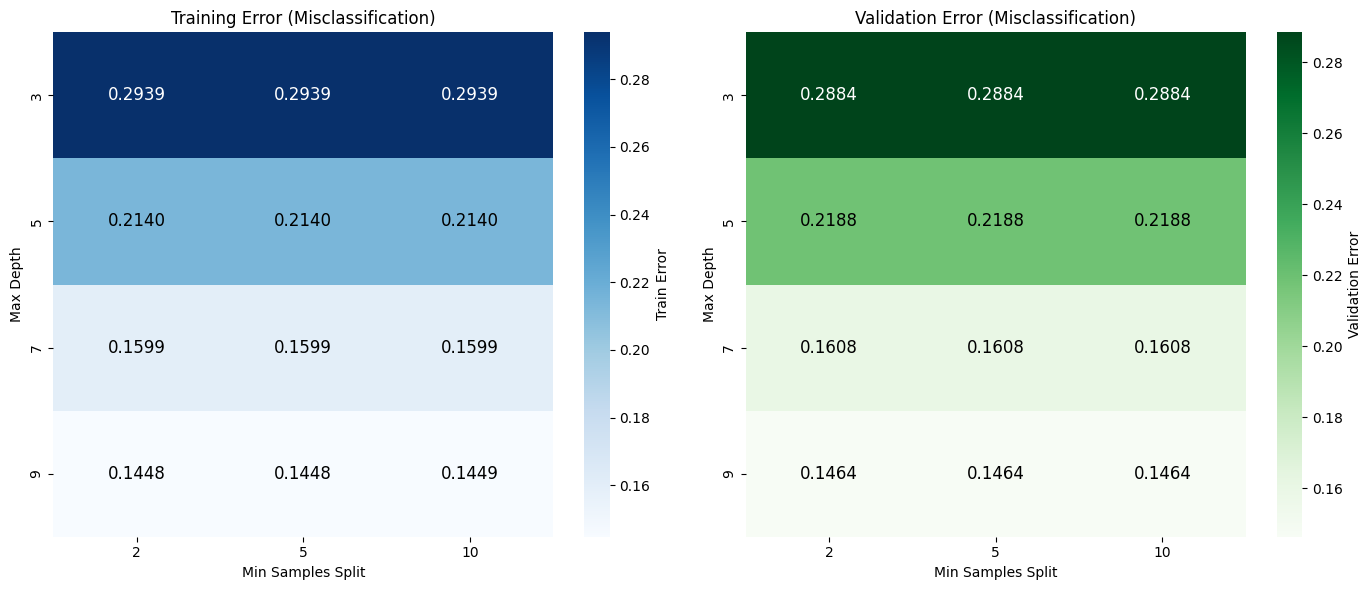

In [27]:
df_results_misclassification = pd.DataFrame(results_misclassification, columns=["Depth", "MinSplit", "TrainErr", "ValErr"])

pivot_train_error = df_results_misclassification.pivot(index="Depth", columns="MinSplit", values="TrainErr")
pivot_val_error = df_results_misclassification.pivot(index="Depth", columns="MinSplit", values="ValErr")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training Error Heatmap
sns.heatmap(
    pivot_train_error,
    annot=False,
    fmt=".4f",
    cmap="Blues",
    ax=axes[0],
    cbar_kws={"label": "Train Error"}
)
annotate_heatmap_with_contrast(axes[0], pivot_train_error)
axes[0].set_title("Training Error (Misclassification)")
axes[0].set_xlabel("Min Samples Split")
axes[0].set_ylabel("Max Depth")

# Validation Error Heatmap
sns.heatmap(
    pivot_val_error,
    annot=False,
    fmt=".4f",
    cmap="Greens",
    ax=axes[1],
    cbar_kws={"label": "Validation Error"}
)
annotate_heatmap_with_contrast(axes[1], pivot_val_error)
axes[1].set_title("Validation Error (Misclassification)")
axes[1].set_xlabel("Min Samples Split")
axes[1].set_ylabel("Max Depth")

plt.tight_layout()
plt.show()


### Final Evaluation (Decision Tree)

After hyperparameters are selected, the final model is retrained on the combined training + validation data and evaluated on the independent test set.
This ensures a fair estimate of generalization accuracy.

In [28]:
# Combining train and validation set for final training
X_train_val = np.vstack([X_train_full, X_val])
y_train_val = np.concatenate([y_train_full, y_val])

In [29]:
final_tree = TreePredictor(max_depth=9, min_samples_split=2, criterion="gini")
final_tree.fit(X_train_val, y_train_val)

y_test_pred = final_tree.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Decision Tree Test Accuracy (Gini): {test_acc:.4f}")

Decision Tree Test Accuracy (Gini): 0.8646


In [30]:
tree_entropy = TreePredictor(max_depth=9, min_samples_split=2, criterion="entropy")
tree_entropy.fit(X_train_val, y_train_val)
y_test_pred_entropy = tree_entropy.predict(X_test)
test_acc_entropy = accuracy_score(y_test, y_test_pred_entropy)
print(f"Decision Tree Test Accuracy (Entropy): {test_acc_entropy:.4f}")

Decision Tree Test Accuracy (Entropy): 0.8708


In [31]:
tree_misclass = TreePredictor(max_depth=9, min_samples_split=2, criterion="error")
tree_misclass.fit(X_train_val, y_train_val)
y_test_pred_misclass = tree_misclass.predict(X_test)
test_acc_misclass = accuracy_score(y_test, y_test_pred_misclass)
print(f"Decision Tree Test Accuracy (Misclassification): {test_acc_misclass:.4f}")

Decision Tree Test Accuracy (Misclassification): 0.8451


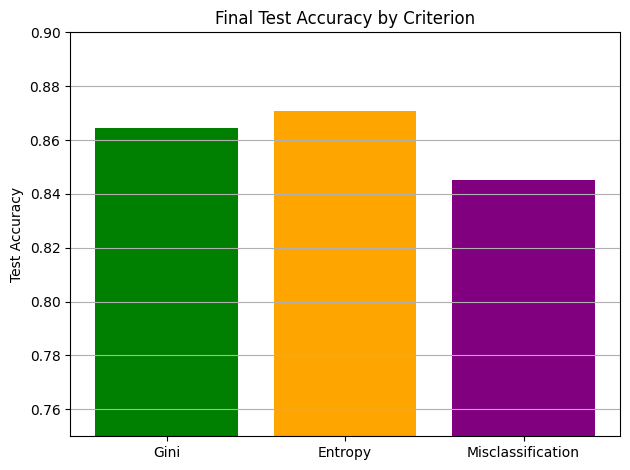

In [32]:
plt.bar(["Gini", "Entropy", "Misclassification"], [test_acc, test_acc_entropy, test_acc_misclass], color=["green", "orange", "purple"])
plt.ylabel("Test Accuracy")
plt.title("Final Test Accuracy by Criterion")
plt.ylim(0.75, 0.90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

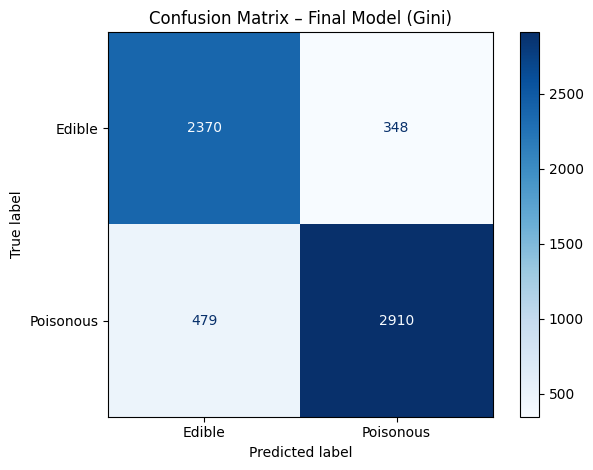

In [33]:
# Confusion Matrix — Gini
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Edible", "Poisonous"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Final Model (Gini)")
plt.tight_layout()
plt.show()

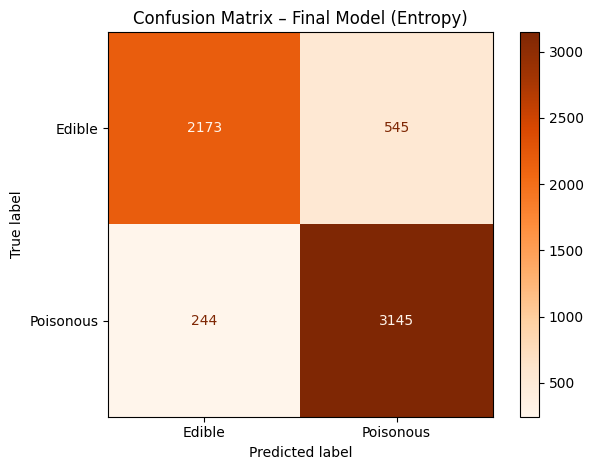

In [34]:
# Confusion Matrix — Entropy
cm_entropy = confusion_matrix(y_test, y_test_pred_entropy)
disp_entropy = ConfusionMatrixDisplay(confusion_matrix=cm_entropy, display_labels=["Edible", "Poisonous"])
disp_entropy.plot(cmap="Oranges")
plt.title("Confusion Matrix – Final Model (Entropy)")
plt.tight_layout()
plt.show()

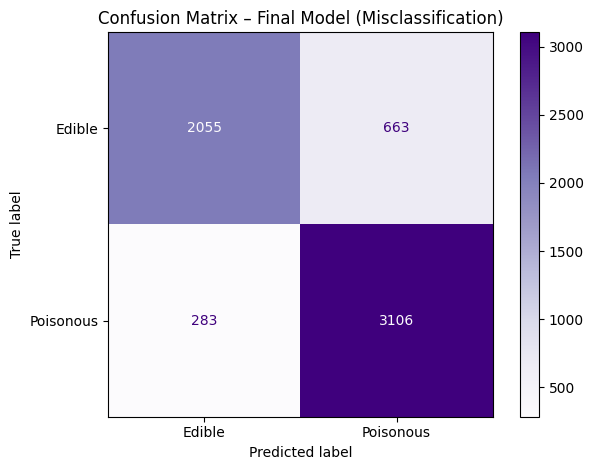

In [35]:
# Confusion Matrix — Misclassification 
cm_misclass = confusion_matrix(y_test, y_test_pred_misclass)
disp_misclass = ConfusionMatrixDisplay(confusion_matrix=cm_misclass, display_labels=["Edible", "Poisonous"])
disp_misclass.plot(cmap="Purples")
plt.title("Confusion Matrix – Final Model (Misclassification)")
plt.tight_layout()
plt.show()

### Random Forest Classifier


In [36]:
class RandomForestPredictor:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2, criterion="gini", random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.trees = []
        self.random_state = random_state

        if self.random_state is not None:
            np.random.seed(self.random_state)

    def _bootstrap_sample(self, X, y):
        n = len(X)
        indices = np.random.choice(n, size=n, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        self.trees = []
        for i in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree = TreePredictor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                criterion=self.criterion
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        majority_vote = np.round(predictions.mean(axis=0)).astype(int)
        return majority_vote

In [37]:
forest = RandomForestPredictor(
    n_estimators=10,
    max_depth=9,
    min_samples_split=2,
    criterion="gini",
    random_state=42 
)

forest.fit(X_train_full, y_train_full)
y_test_pred_rf = forest.predict(X_test)

acc_rf = accuracy_score(y_test, y_test_pred_rf)
test_error_rf = 1 - acc_rf

print(f"Random Forest Test Accuracy: {acc_rf:.4f}")
print(f"Random Forest Test Error (0-1 loss): {test_error_rf:.4f}")

Random Forest Test Accuracy: 0.9484
Random Forest Test Error (0-1 loss): 0.0516


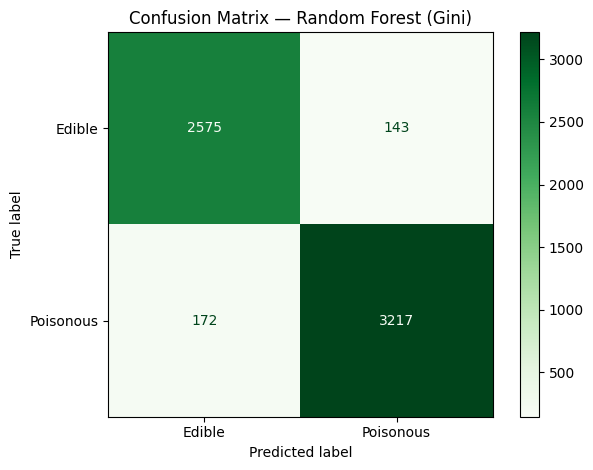

In [39]:
cm_rf = confusion_matrix(y_test, y_test_pred_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Edible", "Poisonous"])
disp_rf.plot(cmap="Greens")
plt.title("Confusion Matrix — Random Forest (Gini)")
plt.tight_layout()
plt.show()

### Model Comparison

In [42]:
print("Final Classification Report — Best Decision Tree (Entropy):")
print(classification_report(y_test, y_test_pred_entropy, target_names=["edible", "poisonous"]))

print("Final Classification Report — Random Forest:")
print(classification_report(y_test, y_test_pred_rf, target_names=["edible", "poisonous"]))

Final Classification Report — Best Decision Tree (Entropy):
              precision    recall  f1-score   support

      edible       0.90      0.80      0.85      2718
   poisonous       0.85      0.93      0.89      3389

    accuracy                           0.87      6107
   macro avg       0.88      0.86      0.87      6107
weighted avg       0.87      0.87      0.87      6107

Final Classification Report — Random Forest:
              precision    recall  f1-score   support

      edible       0.94      0.95      0.94      2718
   poisonous       0.96      0.95      0.95      3389

    accuracy                           0.95      6107
   macro avg       0.95      0.95      0.95      6107
weighted avg       0.95      0.95      0.95      6107



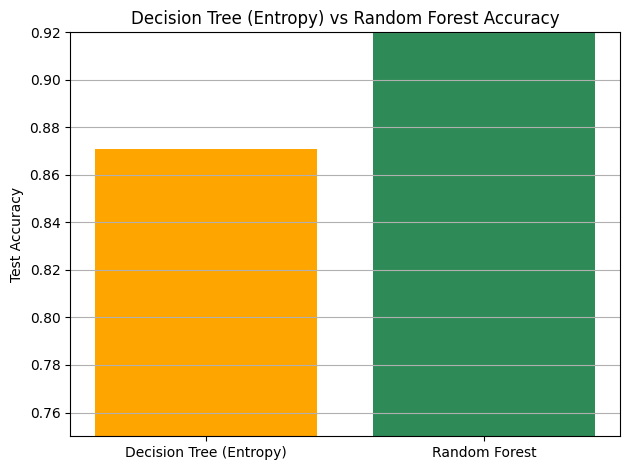

In [43]:
plt.bar(["Decision Tree (Entropy)", "Random Forest"], [test_acc_entropy, acc_rf], color=["orange", "seagreen"])

plt.title("Decision Tree (Entropy) vs Random Forest Accuracy")
plt.ylabel("Test Accuracy")
plt.ylim(0.75, 0.92)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Conclusion

A decision tree and a random forest classifier were successfully implemented from scratch to predict mushroom edibility. Hyperparameter tuning highlights the importance of controlling tree complexity to avoid overfitting. 
The random forest achieved the highest test accuracy, demonstrating improved generalization through ensemble learning. Exploratory data analysis revealed key features such as cap shape and gill color that contribute to classification. Future improvements could include pruning techniques, cross-validation, or integration with other ensemble methods.
